<a href="https://colab.research.google.com/github/ChiNonsoHenry16/Leaf-spot-generation-using-GANs/blob/main/Leaf_Spot_Image_Generation_using_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating the Yam Leaf Spot (YLS) using Deep Convolutional Generative Adversarial Network (DCGAN) is project I decided to do because I discovered it has few images in plant diseases databases such as Lucid Central and none in PlantVillage.

This is to augument the YLS class in the Mbaji Dataset - a collection of yam diseases collected from Otuocha in Anambra State, Nigeria.

A DCGAN is a deep learning model that learns to generate new, realistic images by training two convolutional networks — a Generator that creates fake images and a Discriminator that learns to spot them.

500 Epochs.

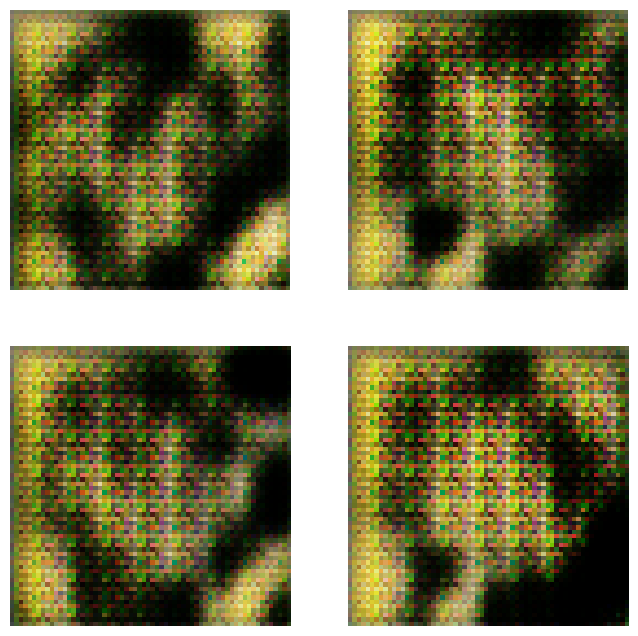

In [1]:
# Setup & GPU check
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

from tensorflow.keras import layers

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load real yam leaf spot images
# Put your few real images in a folder in Drive, e.g., /MyDrive/yam_leaf_spot_real
# Images should be small (e.g., 64x64 or 128x128) for faster training.

DATA_DIR = "/content/drive/MyDrive/Yam Leaf Spot"

IMG_SIZE = 64  # or 128 if you have enough GPU
BATCH_SIZE = 16

def load_images(data_dir, img_size):
    all_images = []
    for filename in glob.glob(os.path.join(data_dir, "*.jpg")):
        img = Image.open(filename).resize((img_size, img_size)).convert('RGB')
        all_images.append(np.array(img))
    return np.array(all_images)

real_images = load_images(DATA_DIR, IMG_SIZE)
real_images = (real_images.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]

print(f"Loaded {len(real_images)} real yam leaf spot images.")

# Create DCGAN generator & discriminator

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the DCGAN

import time
from IPython import display

EPOCHS = 500  # Try with 500 to test first
noise_dim = 100
num_examples_to_generate = 4

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    plt.show()


    # Save to Google Drive
    output_dir = "/content/drive/MyDrive/DCGAN_YamLeafSpot_Generated"
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"epoch_{epoch:04d}.png")
    fig.savefig(filename)
    plt.close(fig)

# Prepare the dataset & train
BUFFER_SIZE = len(real_images)
train_dataset = tf.data.Dataset.from_tensor_slices(real_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset, epochs=500)  # start with 500 for quick testing



More modifications:  better training stability, data augmentation, automatic saving of images, more epochs (2000), and helpful logs.

In [ ]:
# Setup & GPU check
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load real images with optional augmentation
DATA_DIR = "/content/drive/MyDrive/Yam Leaf Spot"
IMG_SIZE = 64  # or 128 if your GPU allows
BATCH_SIZE = 16

# Basic image loading function
def load_images(data_dir, img_size):
    all_images = []
    for filename in glob.glob(os.path.join(data_dir, "*.jpg")):
        img = Image.open(filename).resize((img_size, img_size)).convert('RGB')
        all_images.append(np.array(img))
    return np.array(all_images)

real_images = load_images(DATA_DIR, IMG_SIZE)
real_images = (real_images.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
print(f"Loaded {len(real_images)} real yam leaf spot images.")

# Create data augmentation pipeline (horizontal flip, rotation)
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=15)

# Create DCGAN generator & discriminator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop with augmented batches
import time
from IPython import display

EPOCHS = 5000  # More epochs for better results!
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    # Save to Drive
    output_dir = "/content/drive/MyDrive/DCGAN_YamLeafSpot_Generated"
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"epoch_{epoch:04d}.png")
    fig.savefig(filename)
    plt.close(fig)

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss_list, disc_loss_list = [], []

        for batch in dataset:
            aug_iter = data_gen.flow(batch, batch_size=BATCH_SIZE)
            aug_batch = next(aug_iter)
            gen_loss, disc_loss = train_step(aug_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1}, Gen Loss: {np.mean(gen_loss_list):.4f}, Disc Loss: {np.mean(disc_loss_list):.4f}, Time: {time.time()-start:.2f} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Prepare dataset & train
BUFFER_SIZE = len(real_images)
train_dataset = tf.data.Dataset.from_tensor_slices(real_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)


Epoch 2845, Gen Loss: 1.0069, Disc Loss: 0.9351, Time: 1.31 sec


Visualizing the last 12 generated images

Found 2845 generated images.


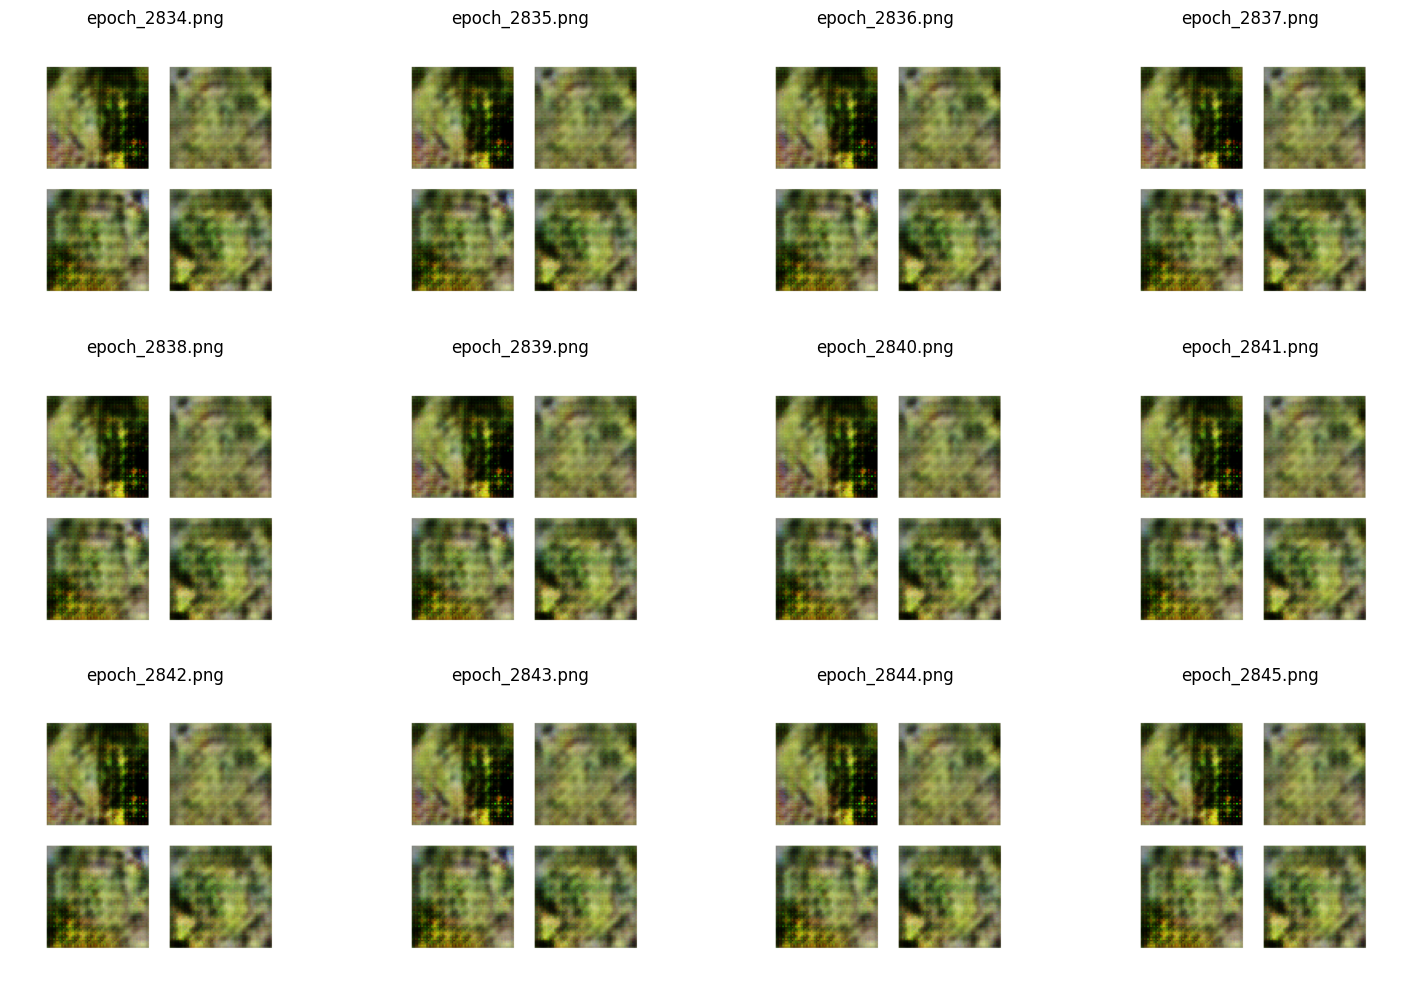

In [3]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Path to saved generated images folder
generated_dir = "/content/drive/MyDrive/DCGAN_YamLeafSpot_Generated"

# Grab all PNG files, sorted by filename (which includes the epoch number)
image_files = sorted(glob.glob(os.path.join(generated_dir, "*.png")))

print(f"Found {len(image_files)} generated images.")

# Select the LAST 12 images
num_to_show = min(12, len(image_files))
last_images = image_files[-num_to_show:]  # last N images

# Plot them in a grid
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(last_images):
    img = Image.open(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')

plt.tight_layout()
plt.show()


WCGAN

In [ ]:
# Setup & GPU check
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load real images + augmentation
DATA_DIR = "/content/drive/MyDrive/Yam Leaf Spot"
IMG_SIZE = 64
BATCH_SIZE = 16

def load_images(data_dir, img_size):
    all_images = []
    for filename in glob.glob(os.path.join(data_dir, "*.jpg")):
        img = Image.open(filename).resize((img_size, img_size)).convert('RGB')
        all_images.append(np.array(img))
    return np.array(all_images)

real_images = load_images(DATA_DIR, IMG_SIZE)
real_images = (real_images.astype('float32') - 127.5) / 127.5
print(f"Loaded {len(real_images)} real yam leaf spot images.")

data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=15)


# WGAN Generator & Critic
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No sigmoid for WGAN
    return model

generator = make_generator_model()
critic = make_critic_model()

# WGAN Loss & Optimizers
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)  # WGAN: maximize critic's output for fake

def critic_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
critic_optimizer = tf.keras.optimizers.RMSprop(5e-5)

# WGAN Training
import time
from IPython import display

EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

critic_clip_value = 0.01  # weight clipping for Lipschitz
critic_updates = 5  # number of critic updates per generator update

@tf.function
def train_step(images):
    for _ in range(critic_updates):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as critic_tape:
            generated_images = generator(noise, training=True)
            real_output = critic(images, training=True)
            fake_output = critic(generated_images, training=True)
            crit_loss = critic_loss(real_output, fake_output)

        gradients_of_critic = critic_tape.gradient(crit_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

        # Weight clipping
        for var in critic.trainable_variables:
            var.assign(tf.clip_by_value(var, -critic_clip_value, critic_clip_value))

    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = critic(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, crit_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')
    output_dir = "/content/drive/MyDrive/WGAN_YamLeafSpot_Generated"
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"epoch_{epoch:04d}.png")
    fig.savefig(filename)
    plt.close(fig)

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss_list, crit_loss_list = [], []

        for batch in dataset:
            aug_iter = data_gen.flow(batch, batch_size=BATCH_SIZE)
            aug_batch = next(aug_iter)
            gen_loss, crit_loss = train_step(aug_batch)
            gen_loss_list.append(gen_loss)
            crit_loss_list.append(crit_loss)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1}, Gen Loss: {np.mean(gen_loss_list):.4f}, Critic Loss: {np.mean(crit_loss_list):.4f}, Time: {time.time()-start:.2f} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


# Prepare dataset & train
BUFFER_SIZE = len(real_images)
train_dataset = tf.data.Dataset.from_tensor_slices(real_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)


Epoch 2618, Gen Loss: -5.9503, Critic Loss: 0.2810, Time: 1.89 sec


The Image is yet not clear

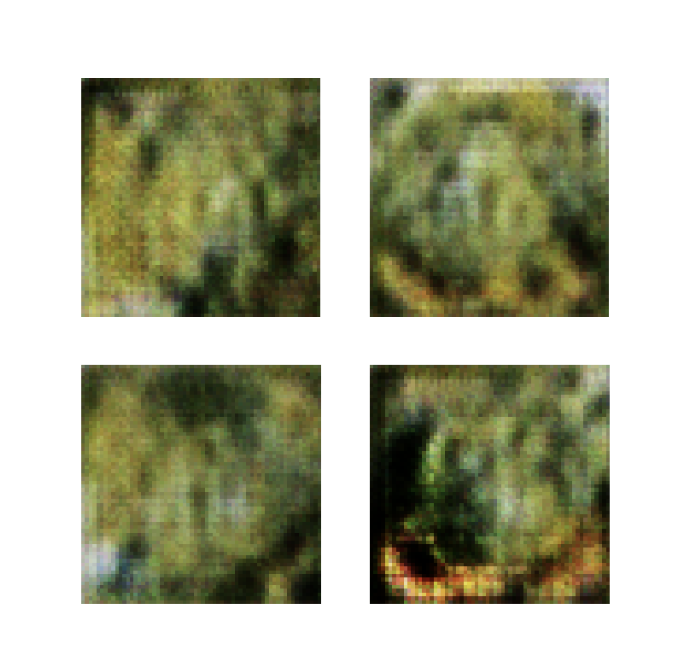